<a href="https://colab.research.google.com/github/jup36/pyDatCode/blob/master/univariate_multistep_lstm_for_power_usage_CoLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Univariate multi-step LSTM for the power usage dataset

#### Mount drive (in Colab)

In [2]:
from google.colab import drive # (in Colab)
drive.mount('/content/drive')

Mounted at /content/drive


#### Imports

In [3]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import os
import matplotlib.pyplot as plt

#### Read csv

In [4]:
colab_path = '/content/drive/My Drive/Colab_data/timeseries_dnn/' 
local_path = '/Volumes/GoogleDrive/My Drive/Colab_data/timeseries_dnn/'
file_name = 'household_power_consumption_days.csv'
# read
dataset = read_csv(os.path.join(colab_path,file_name), infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

#### Split a univariate dataset into train/test sets

In [5]:
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

#### Evaluate one or more weekly forecasts against expected values

In [6]:
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

#### Summarize scores

In [7]:
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

#### Convert history into inputs and outputs

In [8]:
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

#### Train the model

In [59]:
train_y.shape

(1100, 7)

In [9]:
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

#### Make a forecast

In [10]:
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

#### Evaluate a single model

In [49]:
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, model

#### Main Run

In [63]:
# split into train and test
train, test = split_dataset(dataset.values) # splits dataset into train and test sets and reshape them to [samples, timesteps, features] (try train.shape)
# evaluate model and get scores
n_input = 7
score, scores, model = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)


lstm: [454.207] 437.5, 445.0, 409.1, 516.1, 419.1, 331.6, 579.1


#### Plot scores

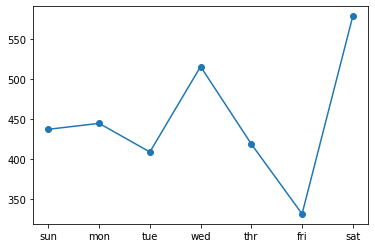

In [14]:
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
plt.plot(days, scores, marker='o', label='lstm')
plt.show()